# Attribution Modeling

Attribution Modeling is a critical concept in marketing analytics that aims to assign credit to various touchpoints in a customer's journey. It helps marketers understand the effectiveness of different channels and optimize their marketing strategies. There are several types of Attribution Models, including First-Touch, Last-Touch, Linear, Time-Decay, and Position-Based. Each model has its own approach to distributing credit, allowing marketers to gain insights into customer behavior and channel performance.

In this notebook, we will explore these different Attribution Models and demonstrate how to implement them using Python. By the end, you will have a solid understanding of Attribution Modeling and how to apply it to your marketing analytics workflow.

# 0. Dataset

We will use the Criteo Attribution Modeling for Bidding Dataset from Kaggle to learn the attribution modeling.

## 0.1. Dataset Profile & Transformation

In [213]:
import pandas as pd
import numpy as np

df = pd.read_csv('datasets/attribution data.csv')

display(df.head())
print('number of records:', len(df))

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


number of records: 586737


In [214]:
# print the dataframe information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [215]:
# transformation, str to datetime for time column

df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   cookie            586737 non-null  object             
 1   time              586737 non-null  datetime64[ns, UTC]
 2   interaction       586737 non-null  object             
 3   conversion        586737 non-null  int64              
 4   conversion_value  586737 non-null  float64            
 5   channel           586737 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(3)
memory usage: 26.9+ MB


From the table, we have total of 6 columns and 586,737 records. The profile of the columns are as follow:

| Field            | Description                                                                                                          |
|------------------|----------------------------------------------------------------------------------------------------------------------|
| Cookie           | A randomly generated customer ID that helps link subsequent visits to the same customer.                            |
| Timestamp        | The date and time of the visit.                                                                                      |
| Interaction      | A categorical variable indicating the type of interaction that occurred.                                             |
| Conversion       | A boolean variable indicating whether a conversion occurred.                                                          |
| Conversion_Value | The value associated with the potential conversion event.                                                            |
| Channel          | The marketing channel through which the customer accesses the site.                                                  |

## 0.2. Dataset Exploration (EDA)

In [216]:
# print nunique for uid and campaign

for col in ['interaction', 'cookie', 'channel']:
    print(f'unique record number for {col}:', df[col].nunique())

unique record number for interaction: 2
unique record number for cookie: 240108
unique record number for channel: 5


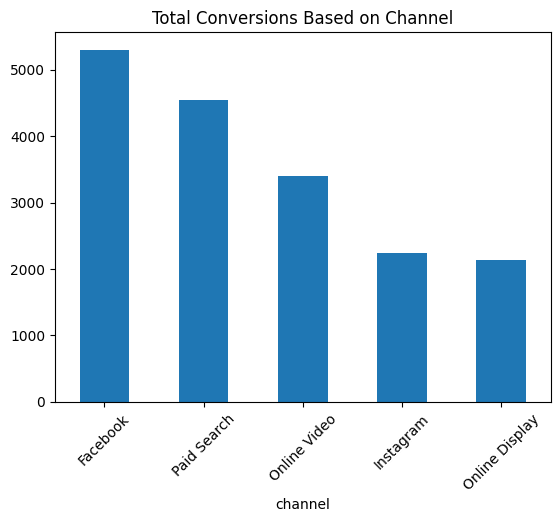

In [217]:
# top 5 campaigns conversion number

import matplotlib.pyplot as plt

df.groupby('channel')['conversion'].sum().sort_values(ascending=False).plot(kind='bar', rot=45)

plt.title('Total Conversions Based on Channel')
plt.show()

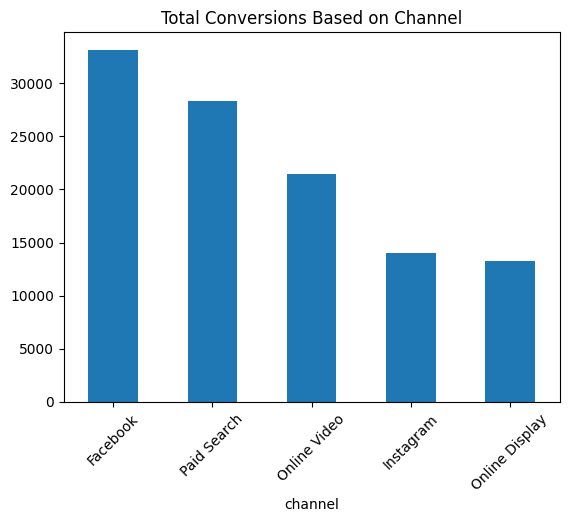

In [218]:
# top 5 campaigns conversion value

import matplotlib.pyplot as plt

df.groupby('channel')['conversion_value'].sum().sort_values(ascending=False).plot(kind='bar', rot=45)

plt.title('Total Conversions Based on Channel')
plt.show()

# 1. Types of Attribution Modeling 

Attribution modeling is a method used in marketing to determine how credit for sales and conversions is assigned to various touchpoints in customer journeys. In essence, it helps marketers understand which marketing channels are most effective in driving conversions. There are several types of attribution models, each with its own way of assigning credit. Here are some common ones:

| Attribution Model          | Description                                                                                                                                                                                                                                                      |
|----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| First Touch Attribution    | This model gives all the credit for a conversion to the first touchpoint a customer interacted with. For example, if a customer first learns about a product through a Facebook ad and later buys it after clicking a Google search ad, the Facebook ad would receive all the credit.                      |
| Last Touch Attribution     | In contrast to first touch, last touch attribution gives all the credit to the last touchpoint before a conversion. Using the same example, the Google search ad would receive all the credit in this model.                                                      |
| Linear Attribution         | This model distributes the credit equally among all touchpoints in the customer journey. So, if a customer goes through five touchpoints before converting, each touchpoint would receive 20% of the credit.                                                    |
| Time Decay Attribution     | This model gives more credit to touchpoints closer to the conversion and less credit to those further away. Touchpoints earlier in the journey receive less credit than those closer to the conversion.                                                          |
| U-Shaped (or Position-Based) Attribution | This model gives 40% of the credit each to the first and last touchpoints, while the remaining 20% is distributed evenly among the touchpoints in between. This acknowledges the importance of both the initial awareness-building touchpoints and the final conversion touchpoints. |
| Custom Attribution Models | Companies can also create custom attribution models based on their specific business needs and customer journey patterns.                                                                                                                                      |


Each attribution model has its strengths and weaknesses, and the choice of model often depends on the specific marketing goals and strategies of a business. Marketers use these models to optimize their marketing efforts by allocating resources to the most effective channels and campaigns.

<img src="images/multi-touch-attribution-models-explained.png" alt="Multi-touch attribution models explained" width="800"/>

Now, let's move on to the example on how we can do this with the dataset we have.

## 1.1. First-touch

In [8]:
# make a duplicate of the current dataframe
# to avoid losing the original dataframe we have

df_first = df.copy(deep=True)

# only take data where the user make a conversion

cookie_conv = df_first[df_first['conversion'] == 1]['cookie'].unique()
df_first = df_first[df_first['cookie'].isin(cookie_conv)]

In [9]:
# check the first touch point of the user with our campaign
# then filter out the data to only include these users

df_first['min_time'] = df_first.groupby('cookie').transform('min')['time']
df_first = df_first[df_first['time'] == df_first['min_time']]

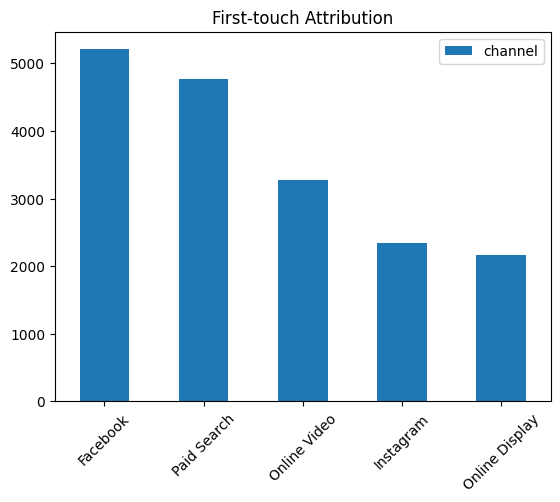

In [10]:
att_first = pd.DataFrame(df_first['channel'].value_counts())
att_first.plot(kind='bar', rot=45)

plt.title('First-touch Attribution')
plt.show()

## 1.2. Last-touch

In [11]:
# make a duplicate of the current dataframe
# to avoid losing the original dataframe we have

df_last = df.copy(deep=True)

# only take data where the user make a conversion

cookie_conv = df_last[df_last['conversion'] == 1]['cookie'].unique()
df_last = df_last[df_last['cookie'].isin(cookie_conv)]

# check the first touch point of the user with our campaign
# then filter out the data to only include these users

df_last['max_time'] = df_last.groupby('cookie').transform('max')['time']
df_last = df_last[df_last['time'] == df_last['max_time']]

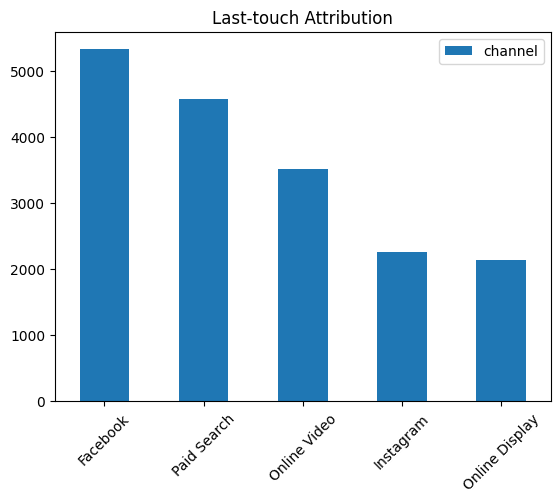

In [12]:
att_last = pd.DataFrame(df_last['channel'].value_counts())
att_last.plot(kind='bar', rot=45)

plt.title('Last-touch Attribution')
plt.show()

## 1.3. Linear Attribution

In [13]:
# make a duplicate of the dataframe for users who are converting
df_linear = df.copy(deep=True)

cookie_conv = df_linear[df_linear['conversion'] == 1]['cookie'].unique()
df_linear = df_linear[df_linear['cookie'].isin(cookie_conv)]

df_linear = df_linear.sort_values(['cookie', 'time']).reset_index(drop=True)

In [14]:
# check number of touchpoints before converting
# and put it as denominator, as the credits are distributed equally

df_linear['n_touchpoints'] = df_linear.groupby('cookie').transform('size')
df_linear['credits'] = 1 / df_linear['n_touchpoints']

df_linear.head()

,cookie,time,interaction,conversion,conversion_value,channel,n_touchpoints,credits
0,0007oEBhnoF97AoEE3BCkFnhB,2018-07-06 13:45:29+00:00,conversion,1,6.5,Paid Search,1,1.000000
1,00090n9EBBEkA000C7Cik999D,2018-07-05 06:53:53+00:00,conversion,1,8.0,Facebook,1,1.000000
2,000h3n9nC0hFhE3CCnkkAof7n,2018-07-19 14:31:57+00:00,conversion,1,6.0,Facebook,1,1.000000
3,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:34:54+00:00,impression,0,0.0,Online Video,24,0.041667
4,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:35:22+00:00,impression,0,0.0,Online Video,24,0.041667


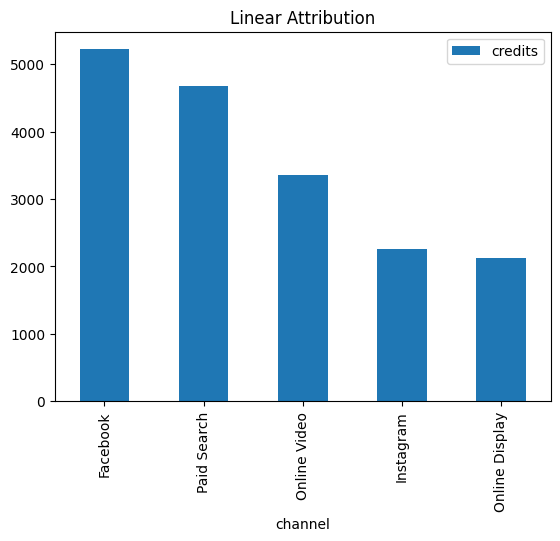

In [15]:
att_linear = pd.DataFrame(df_linear.groupby('channel')['credits'].sum().sort_values(ascending=False))
att_linear.plot(kind='bar')

plt.title('Linear Attribution')
plt.show()

## 1.4. Time Decay

Time decay attribution is a method used in marketing attribution to assign credit to touchpoints based on their proximity to conversion. The idea is that touchpoints closer in time to the conversion event should receive more credit than those further away. One common approach is to use an **exponential decay function** to distribute the credit. The formula for the time decay function is:

$\text{Credit} = \exp(- \lambda \cdot \text{time\_difference})$

Where:
- λ (lambda) is the decay parameter, which controls how quickly the credit diminishes over time. A higher lambda means faster decay.
- time_difference is the time difference between the touchpoint and the conversion event.

After, that we can normalize the credit value to make sure that all the credits will be added up to 1. To normalize the credits, you would calculate the individual credits using the time decay formula, then divide each credit by the sum of all credits

$\text{Normalized Credit}_i = \frac{Credit_i}{\sum_{j=1}^{n} \text{Credit}_j}$

In [16]:
# make a duplicate of the dataframe for users who are converting
df_time = df.copy(deep=True)

cookie_conv = df_time[df_time['conversion'] == 1]['cookie'].unique()
df_time = df_time[df_time['cookie'].isin(cookie_conv)]

df_time = df_time.sort_values(['cookie', 'time']).reset_index(drop=True)

In [17]:
# check the maximum time, to know when the person made a conversion
df_time['conv_time'] = df_time.groupby('cookie')['time'].transform('max')

# check the different time, to know the proximity to the conversion
# and convert it to minute
df_time['diff_time'] = df_time['conv_time'] - df_time['time']
df_time['diff_mins'] = df_time['diff_time'].dt.total_seconds() // 60

df_time.head()

,cookie,time,interaction,conversion,conversion_value,channel,conv_time,diff_time,diff_mins
0,0007oEBhnoF97AoEE3BCkFnhB,2018-07-06 13:45:29+00:00,conversion,1,6.5,Paid Search,2018-07-06 13:45:29+00:00,0 days 00:00:00,0.0
1,00090n9EBBEkA000C7Cik999D,2018-07-05 06:53:53+00:00,conversion,1,8.0,Facebook,2018-07-05 06:53:53+00:00,0 days 00:00:00,0.0
2,000h3n9nC0hFhE3CCnkkAof7n,2018-07-19 14:31:57+00:00,conversion,1,6.0,Facebook,2018-07-19 14:31:57+00:00,0 days 00:00:00,0.0
3,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:34:54+00:00,impression,0,0.0,Online Video,2018-07-25 11:15:16+00:00,17 days 20:40:22,25720.0
4,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:35:22+00:00,impression,0,0.0,Online Video,2018-07-25 11:15:16+00:00,17 days 20:39:54,25719.0


In [18]:
# set the lambda here, the higher the lambda, channel will decay faster
lambda_val = 0.0001

# calculate the credits by using the formula above
df_time['credits'] = np.exp(-lambda_val * df_time['diff_mins'])

# normalize the credits to make it added up to 1
sum_creds = df_time.groupby('cookie')['credits'].transform('sum')
df_time['normalized_credits'] = df_time['credits'] / sum_creds

df_time.head()

,cookie,time,interaction,conversion,conversion_value,channel,conv_time,diff_time,diff_mins,credits,normalized_credits
0,0007oEBhnoF97AoEE3BCkFnhB,2018-07-06 13:45:29+00:00,conversion,1,6.5,Paid Search,2018-07-06 13:45:29+00:00,0 days 00:00:00,0.0,1.000000,1.000000
1,00090n9EBBEkA000C7Cik999D,2018-07-05 06:53:53+00:00,conversion,1,8.0,Facebook,2018-07-05 06:53:53+00:00,0 days 00:00:00,0.0,1.000000,1.000000
2,000h3n9nC0hFhE3CCnkkAof7n,2018-07-19 14:31:57+00:00,conversion,1,6.0,Facebook,2018-07-19 14:31:57+00:00,0 days 00:00:00,0.0,1.000000,1.000000
3,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:34:54+00:00,impression,0,0.0,Online Video,2018-07-25 11:15:16+00:00,17 days 20:40:22,25720.0,0.076383,0.006655
4,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:35:22+00:00,impression,0,0.0,Online Video,2018-07-25 11:15:16+00:00,17 days 20:39:54,25719.0,0.076390,0.006656


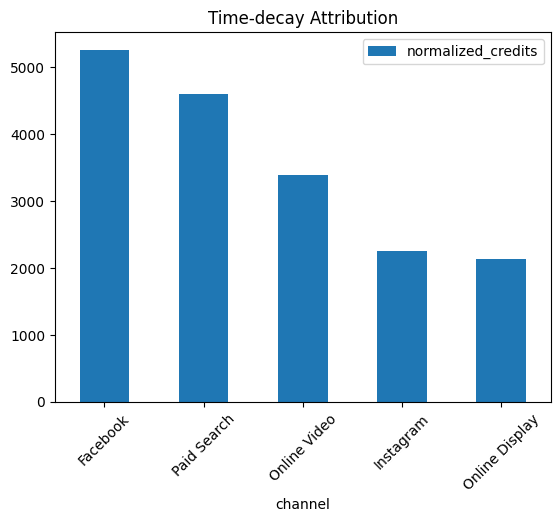

In [19]:
att_time = pd.DataFrame(df_time.groupby('channel')['normalized_credits'].sum().sort_values(ascending=False))
att_time.plot(kind='bar', rot=45)

plt.title('Time-decay Attribution')
plt.show()

## 1.5. Position-Based or U-shaped Attribution Models

Position-based attribution models, also known as U-shaped attribution models, assign credit to different touchpoints in a customer journey based on their position. In a typical U-shaped model, **the first and last touchpoints each receive 40% of the credit, while the remaining 20% is distributed evenly** among the intermediate touchpoints. The formula for calculating the credit for each touchpoint in a U-shaped attribution model is as follows:

Let $n$ be the total number of touchpoints in a customer journey, $C$ be the total number of conversions, and $\text{Conv}_i$ be an indicator variable for whether touchpoint $i$ resulted in a conversion (1 for conversion, 0 for no conversion).

The credit assigned to each touchpoint is calculated as follows:

1. **First Touchpoint (FT):** $\text{Credit}_{\text{FT}} = 0.4 \times C$
2. **Last Touchpoint (LT):** $\text{Credit}_{\text{LT}} = 0.4 \times C$
3. **Intermediate Touchpoints (IT):** $\text{Credit}_{\text{IT}} = \frac{0.2 \times C}{n - 2}$

However, when there is only one touchpoint or only two touchpoints before converting:

1. **Single Touchpoint (ST):** $\text{Credit}_{\text{ST}} = C$ (where $C$ is the total number of conversions).
2. **Two Touchpoints (TT) Before Converting:** $\text{Credit}_{\text{TT}} = 0.5 \times C$ for each of the two touchpoints.

The total credit assigned to each touchpoint $i$ can be represented as:

$\text{Credit}_i = \begin{cases} \text{Credit}_{\text{FT}} & \text{if } i = 1 \\ \text{Credit}_{\text{LT}} & \text{if } i = n \\ \text{Credit}_{\text{IT}} & \text{if } 1 < i < n \end{cases}$

In this model, the first and last touchpoints each receive 40% of the credit, while the remaining 20% is distributed evenly among the intermediate touchpoints.

In [20]:
# make a duplicate of the dataframe for users who are converting
df_pos = df.copy(deep=True)

cookie_conv = df_pos[df_pos['conversion'] == 1]['cookie'].unique()
df_pos = df_pos[df_pos['cookie'].isin(cookie_conv)]

df_pos = df_pos.sort_values(['cookie', 'time']).reset_index(drop=True)

In [21]:
df_pos['n_touchpoints'] = df_pos.groupby('cookie').transform('size')
df_pos['pos_touchpoints'] = df_pos.groupby('cookie').cumcount() + 1

In [22]:
# first and last touchpoint weight, you can adjust here
# usually, the weight is set at 40%
fl_weight = 0.4

# now, we calculate using the formula above
for i in range(len(df_pos)):
    if df_pos.loc[i, 'n_touchpoints'] == 1:
        df_pos.loc[i, 'credits'] = 1
    elif df_pos.loc[i, 'n_touchpoints'] == 2:
        df_pos.loc[i, 'credits'] = 0.5
    else:
        if df_pos.loc[i, 'pos_touchpoints'] == 1 or df_pos.loc[i, 'pos_touchpoints'] == df_pos.loc[i, 'n_touchpoints']:
            df_pos.loc[i, 'credits'] = fl_weight
        else:
            df_pos.loc[i, 'credits'] = (1 - (fl_weight * 2)) / (df_pos.loc[i, 'n_touchpoints'] - 2)

df_pos.head()

,cookie,time,interaction,conversion,conversion_value,channel,n_touchpoints,pos_touchpoints,credits
0,0007oEBhnoF97AoEE3BCkFnhB,2018-07-06 13:45:29+00:00,conversion,1,6.5,Paid Search,1,1,1.000000
1,00090n9EBBEkA000C7Cik999D,2018-07-05 06:53:53+00:00,conversion,1,8.0,Facebook,1,1,1.000000
2,000h3n9nC0hFhE3CCnkkAof7n,2018-07-19 14:31:57+00:00,conversion,1,6.0,Facebook,1,1,1.000000
3,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:34:54+00:00,impression,0,0.0,Online Video,24,1,0.400000
4,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:35:22+00:00,impression,0,0.0,Online Video,24,2,0.009091


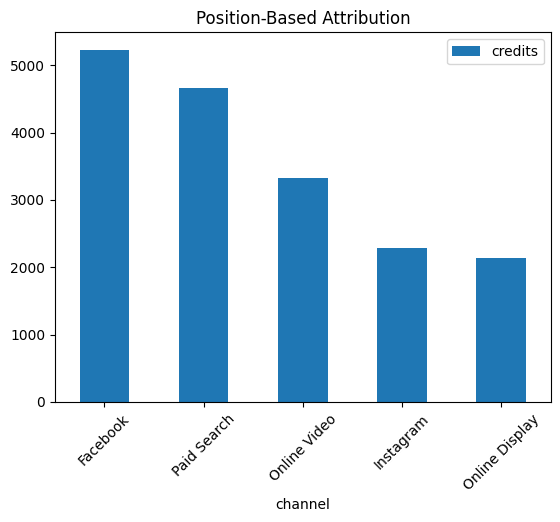

In [23]:
att_pos = pd.DataFrame(df_pos.groupby('channel')['credits'].sum().sort_values(ascending=False))
att_pos.plot(kind='bar', rot=45)

plt.title('Position-Based Attribution')
plt.show()

## 1.6. Evaluation and Comparison of All Types

In [24]:
# combine all attribution modeling into a single dataframe
att_all = pd.concat([att_first, att_last, att_linear, att_time, att_pos], 
                    axis=1,
                    keys=['att_first', 'att_last', 'att_linear', 'att_time', 'att_pos'])

att_all.columns = att_all.columns.droplevel(1)
att_all = round(att_all, 2)

att_all 

,att_first,att_last,att_linear,att_time,att_pos
Facebook,5206,5334,5218.90,5259.85,5228.18
Paid Search,4773,4575,4681.20,4596.19,4664.28
Online Video,3272,3518,3349.40,3390.67,3323.59
Instagram,2347,2263,2265.18,2259.40,2281.03
Online Display,2165,2147,2124.32,2132.90,2141.91


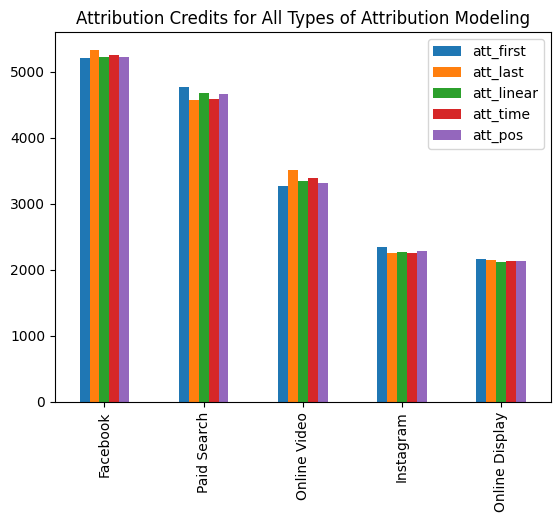

In [25]:
att_all.plot(kind='bar')

plt.title('Attribution Credits for All Types of Attribution Modeling')
plt.show()

# 2. Attribution Modeling Using Markov Chain

Markov chain is a mathematical model that describes a sequence of events where the probability of transitioning to the next state depends only on the current state. In attribution modeling, the states typically represent different marketing channels or touchpoints, and the transitions between states represent the customer journey through these channels. Before moving further, let's get us introduced first with the theory and basic of the Markov Chain method.

## 2.1. Theory

### 2.1.1. Introduction to Markov Chain

Certainly! A Markov chain is a `stochastic process` that satisfies the Markov property, which states that the conditional probability distribution of future states depends only on the current state and not on the sequence of events that preceded it. Mathematically, a Markov chain can be defined as follows:

1. **State Space**: Let $S = \{S_1, S_2, \ldots, S_n\}$ be the finite set of states in the Markov chain.
2. **Transition Probability Matrix**: Let $P = [p_{ij}]$ be the transition probability matrix, where $p_{ij}$ represents the probability of transitioning from state $S_i$ to state $S_j$. The matrix $P$ has the property that for each row $i$, $\sum_{j=1}^n p_{ij} = 1$, since the probabilities of transitioning to all possible states from state $S_i$ must sum to 1.
3. **Initial State Probability Vector**: Let $\pi = [\pi_1, \pi_2, \ldots, \pi_n]$ be the initial state probability vector, where $\pi_i$ represents the probability of starting the chain in state $S_i$. The vector $\pi$ has the property that $\sum_{i=1}^n \pi_i = 1$.

Given the transition probability matrix $P$ and the initial state probability vector $\pi$, the probability of the chain being in state $S_j$ after $k$ steps (denoted as $P(X_k = S_j)$) can be calculated as:

$P(X_k = S_j) = \sum_{i=1}^n \pi_i \cdot p_{ij}^k$

This formula represents the probability of transitioning from all possible initial states $S_i$ to state $S_j$ in exactly $k$ steps.

### 2.1.2. Markov Chain as Stochastic Process

You might notice in the definition of Markov Chain that it is a stochastic process. However, **what does it mean by stochastic process?**

A stochastic process is a mathematical model that describes the evolution of a system over time where outcomes are partially random. In other words, it is a collection of random variables representing the evolution of some system over time or space. In the context of a Markov chain, it is a specific type of stochastic process where the next state of the system depends only on the current state and not on the sequence of events that preceded it. This property is known as the Markov property, and it simplifies the modeling of complex systems by focusing on the current state and its immediate implications, rather than considering the entire history of the system.

### 2.1.3. Example of Markov Chain

To understand more about markov chain, let's take a look at the example below:

<figure>
  <img src="images/markov-state-ex.png" alt="Example of Markov Chain diagram" width="800"/>
  <figcaption>Taken from: <a href="https://en.m.wikipedia.org/wiki/File:Finance_Markov_chain_example_state_space.svg">Wikipedia</a></figcaption>
</figure>

Consider creating a model for stock market fluctuations using the Markov chain. In this model, you would define scenarios such as "bullish," "bearish," and "stagnant" as distinct states representing the various conditions the stock market can exhibit. These states, along with other behaviors, constitute what is known as a ‘state space’ — essentially, a comprehensive list of all possible situations the stock market could experience. The Markov chain then aids in determining the probability of the stock market transitioning from one state to another. For instance, it could help ascertain the likelihood of a bullish stock market transitioning to a bearish state in the next period.

### 2.1.4. Transition Matrix

In practice, modelers typically use a "transition matrix" to represent Markov chains instead of drawing diagrams. This matrix lists every state in the state space as both a row and a column. Each cell in the matrix indicates the probability of transitioning from the state corresponding to its row to the state corresponding to its column. Essentially, the cells in the matrix serve the same purpose as the arrows in the diagram. Take a look at the example below between movemenet from two states, A and B.

<figure>
  <img src="images/transition-matrix.png" alt="Transition Matrix" width="800"/>
  <figcaption>Taken from: <a href="https://setosa.io/ev/markov-chains/">setosa.io</a></figcaption>
</figure>

When a new state is added to the state space in a Markov chain, we must add one row and one column to the transition matrix, resulting in one additional cell for each existing column and row. This leads to a quadratic increase in the number of cells as we add more states to the Markov chain. Consequently, using a transition matrix becomes much more practical than attempting to represent the chain with a complex diagram as the number of states grows.

### 2.1.5. Removal Effect

The main essence of Markov Model is the Removal Effect. It refers to the impact of removing or excluding a particular state from the state space of the Markov chain. When a state is removed, the dynamics of the Markov chain change, potentially altering the probabilities of transitioning between other states.

In the attribution modeling, removal effect helps us to measure how much each marketing channel contributes to generating conversions. We achieve this by systematically taking out each channel from the overall picture and observing the resulting impact on conversions. The greater the impact, the more value is assigned to that specific channel. This process is repeated for each channel, allowing us to gauge their influence on conversions.

#### 2.1.5.1 Example 1

Let's take a look at the example from <a href='https://medium.com/@akanksha.etc302/attribution-modeling-using-markov-chain-88fc6c0a499e'>Akanksha Anand article on Medium</a> to compute the Removal Effect, we begin by figuring out the likelihood of all paths leading to conversions. The table below illustrates this, including the overall probability of conversion considering all possible paths. When we add up all the probabilities, we find that the total likelihood of conversion is approximately 64%.

| Sequence| Path| Calculation  | Probability |
|---|---|---|---|
| Path1 | Start > Email > Conversions| 70% x 50% | 0.35 |
| Path2 | Start > Email > Display > Social > Conversions | 70% x 50% x 50% x 90% | 0.1575 |
| Path3 | Start > Display > Social > Conversions | 30% x 50% x 90% | 0.135       |
| | All Paths | | 0.6425 |

After calculating the conversion probability, we can begin eliminating each channel individually to compute the removal effect using the formula below:

$\text{Removal Effect} = 1 - (\frac{\text{path\_probability}}{\text{total\_probability}})$

| Sequence | Probability | Without Email | Without Display | Without Social |
|---|---|---|---|---|
| Path1 | 0.35 | N | Y (1-(0.35/0.6425) = 0.46) | Y (1-(0.35/0.6425) = 0.46) |
| Path2 | 0.1575 | N | N | N |
| Path3 | 0.135 | Y (1-(0.135/0.6425) = 0.79) | N | N |

Referring to the table above, removing Email from the marketing channel would impact 79% of conversions. Likewise, eliminating Display and Social would result in a 46% decrease in conversions. To simplify the interpretation, we can **standardize the Removal Effect, which directly reflects the percentage of the total value attributed to the channel.**

| Channel | Removal Effect | Normalized Removal Effect |
|---|---|---|
| Email | 0.79 | 0.46 |
| Display | 0.46 | 0.27 |
| Social | 0.46 | 0.27 |
| Total | 1.71 | 1.00 |

**Note:** The sum of the normalized removal effects (0.46 + 0.27 + 0.27) is 1.00, which should be in the total cell. 

#### 2.1.5.1 Example 2

If you're still unsure about the process, consider this example from <a href='https://medium.com/@aditya2590/multi-channel-attribution-modelling-with-markov-chains-fbf3bdab2ca8'>Aditya Saxena's article on Medium</a>. Let's imagine we have three customers, each navigating through various channels until they either completed a conversion or did not.

| Customer | Channels | Converted |
|---|---|---|
| Customer 1 | C1 -> C2 -> C3 | Yes |
| Customer 2 | C1 | No |
| Customer 3 | C2 -> C3 | No |

Based on the table above, we can create a transition matrix as follows:

| Start | c1   | c2   | c3   | yes  | no   |
|-------|------|------|------|------|------|
| **Start** | 0.00 | 0.67 | 0.33 | 0.00 | 0.00 |
| c1    | 0.00 | 0.50 | 0.00 | 0.00 | 0.50 |
| c2    | 0.00 | 0.00 | 0.00 | 1.00 | 0.00 |
| c3    | 0.00 | 0.00 | 0.00 | 0.50 | 0.50 |
| yes   | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 |
| no    | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 |

To interpret the table above, we can treat the index as the previous state and the columns as the current state. For example, the probability of a user transitioning from the "start" state to the "c2" state is 0.67. The sum of probabilities in each row should equal 1. However, for "yes" and "no" state, we can put the probability as zero as they're the final state of every path. We can represent this in a diagram as follows:

<img src="images/transition-diagram.png" alt="Transition Diagram Example" width="800"/>

Now, let's get our hands dirty by doing practice with the previous data that we have!

## 2.2. Practice

In [26]:
# display dataframe snippet as a refresher

display(df.head())
print('number of records of the dataframe:', len(df))

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


number of records of the dataframe: 586737


### 2.2.1. Data Preprocessing

In [27]:
df_markov = df.copy(deep=True)

df_markov = df_markov.sort_values(['cookie', 'time'])
df_markov['state_pos'] = df_markov.groupby('cookie').cumcount() + 1

df_markov.head()

,cookie,time,interaction,conversion,conversion_value,channel,state_pos
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1


In [170]:
# create df_conversion, showing whether a user convert or not convert
df_conversion = df_markov.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]

# groupby cookie and concat all strings as 'paths' column to show the path a user went through
df_paths = df_markov.groupby('cookie').agg(paths=('channel', lambda x: ', '.join(map(str, x))))

# merge with df_conversion and reset index
df_paths = pd.merge(df_conversion, df_paths, left_on='cookie', right_index=True)
df_paths = df_paths.reset_index(drop=True)

# concat "start" at the beginning of the path
# if no conversion made, we append "no_conv", otherwise "conv"
df_paths['paths'] = np.where(
    df_paths['conversion'] == 0,
    'Start, ' + df_paths['paths'] + ', No_Conv',
    'Start, ' + df_paths['paths'] + ', Conv'
)

# finalize the 'paths' column by converting it into a list
df_paths['paths'] = df_paths['paths'].str.split(', ')

df_paths.head()

,cookie,conversion,paths
0,00000FkCnDfDDf0iC97iC703B,0,"[Start, Instagram, Online Display, Online Disp..."
1,0000nACkD9nFkBBDECD3ki00E,0,"[Start, Paid Search, Paid Search, Paid Search,..."
2,0003EfE37E93D0BC03iBhBBhF,0,"[Start, Paid Search, Paid Search, Paid Search,..."
3,00073CFE3FoFCn70fBhB3kfon,0,"[Start, Instagram, No_Conv]"
4,00079hhBkDF3k3kDkiFi9EFAD,0,"[Start, Paid Search, No_Conv]"


### 2.2.2. Markov Chain Analysis

1. **Calculate the conversion rate first.** Easy. We can just calculate total number of conversions divided by number of paths. Mathemtical notation is shown as follow:

- $\text{Conversion Rate} = \frac{\text{Total conversions}}{\text{Total number of paths}}$

In [171]:
paths_list = df_paths['paths']
total_conv = sum(path.count('Conv') for path in df_paths['paths'])
conv_rate = total_conv / len(paths_list)

conv_rate

0.07346277508454528

2. **Generate the unique combinations of user journeys possible with the available set of channels.** These unique journey combinations are used to create transition_states, where each combination is assigned a value of 0.

In [172]:
# make a set of all unique channel list for creating transition states
unique_channel_list = set(x for element in paths_list for x in element)

# create transition states from the unique channel list, and assign the value with 0 first
transition_states = {x + '>' + y: 0 for x in unique_channel_list for y in unique_channel_list}

# check what inside both of the objects
print(unique_channel_list)
print(transition_states)

{'Conv', 'Instagram', 'Facebook', 'Start', 'No_Conv', 'Online Video', 'Online Display', 'Paid Search'}
{'Conv>Conv': 0, 'Conv>Instagram': 0, 'Conv>Facebook': 0, 'Conv>Start': 0, 'Conv>No_Conv': 0, 'Conv>Online Video': 0, 'Conv>Online Display': 0, 'Conv>Paid Search': 0, 'Instagram>Conv': 0, 'Instagram>Instagram': 0, 'Instagram>Facebook': 0, 'Instagram>Start': 0, 'Instagram>No_Conv': 0, 'Instagram>Online Video': 0, 'Instagram>Online Display': 0, 'Instagram>Paid Search': 0, 'Facebook>Conv': 0, 'Facebook>Instagram': 0, 'Facebook>Facebook': 0, 'Facebook>Start': 0, 'Facebook>No_Conv': 0, 'Facebook>Online Video': 0, 'Facebook>Online Display': 0, 'Facebook>Paid Search': 0, 'Start>Conv': 0, 'Start>Instagram': 0, 'Start>Facebook': 0, 'Start>Start': 0, 'Start>No_Conv': 0, 'Start>Online Video': 0, 'Start>Online Display': 0, 'Start>Paid Search': 0, 'No_Conv>Conv': 0, 'No_Conv>Instagram': 0, 'No_Conv>Facebook': 0, 'No_Conv>Start': 0, 'No_Conv>No_Conv': 0, 'No_Conv>Online Video': 0, 'No_Conv>Online D

3. **Update the transition_states** variable based on the occurrences in the dataset.

In [173]:
for possible_state in unique_channel_list:
    # exclude conversion / no_conversion values from the calculations.
    if possible_state not in ['Conv', 'No_Conv']:
        # iterates over the path list we have
        for user_path in paths_list:
            # checks if the possible_state is present in the current user_path
            if possible_state in user_path:
                # creates a list indices that contains the indices of the user_path where possible_state occurs.
                indices = [i for i, s in enumerate(user_path) if possible_state in s]
                for col in indices:
                    # updates the transition_states dictionary. 
                    # extracts the current channel (user_path[col]) and the next channel (user_path[col + 1]) from the user_path, 
                    # concatenates them with '>', and uses the result as a key in the transition_states dictionary. 
                    # then increments the value associated with that key by 1, indicating the transition from the current channel to the next channel.
                    transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

4. **Calculate the transition probabilities** by iterating through all the paths taken by a user. For each path, we calculate the ratio of favorable outcomes to the total number of possible outcomes.

In [187]:
from collections import defaultdict

# imports the defaultdict class from the collections module. 
# defaultdict is a subclass of the built-in dict class that allows you to provide a default value for new keys
# in defaultdict, when you try to access a key that doesn't exist, it will create the key and initialize it with the default value
transition_prob = defaultdict(dict)

for state in unique_channel_list:
    # exclude conversion and no_conversion state from the calculation
    if state not in ['Conv', 'No_Conv']:
        # counter, used to calculate the total number of transitions involving the current state.
        counter = 0
        index = [i for i, s in enumerate(transition_states) if state + '>' in s]
        
        # first iteration, to count the number of transitions for the current transition state
        for col in index:
            # if the transition count for the current transition state is greater than 0
            # increments the counter by the number of transitions for the current transition state
            if transition_states[list(transition_states)[col]] > 0:
                counter += transition_states[list(transition_states)[col]]
        
        # restart the iteration, to keep the counter 
        for col in index:
            # calculates the transition probability for the current transition state
            # it divides the number of transitions for the current state by the total number of transitions involving the current state
            if transition_states[list(transition_states)[col]] > 0:
                state_prob = float((transition_states[list(transition_states)[col]])) / float(counter)
                transition_prob[list(transition_states)[col]] = state_prob

transition_prob

defaultdict(dict,
            {'Instagram>Conv': 0.0298400287230223,
             'Instagram>Instagram': 0.15958564380792808,
             'Instagram>Facebook': 0.3725216419994415,
             'Instagram>No_Conv': 0.3637717583542772,
             'Instagram>Online Video': 0.022247044587173043,
             'Instagram>Online Display': 0.018683262190662357,
             'Instagram>Paid Search': 0.033350620337495515,
             'Facebook>Conv': 0.030163706818556853,
             'Facebook>Instagram': 0.15939365316004803,
             'Facebook>Facebook': 0.3731400185500253,
             'Facebook>No_Conv': 0.36310821037777186,
             'Facebook>Online Video': 0.021986901178438725,
             'Facebook>Online Display': 0.01819723342873888,
             'Facebook>Paid Search': 0.034010276486420354,
             'Start>Instagram': 0.11918803205224315,
             'Start>Facebook': 0.2784080497109634,
             'Start>Online Video': 0.14236093757808985,
             'Start>Onlin

5. Before delving into calculating the Removal Effect, we **calculate the transition matrix** by using matrix manipulations to calculate the probabilities after the removal of each channel. To do this, we create a new dataset called transition_matrix, where each entry is assigned the transition probability calculated in the previous step.

In [185]:
transition_matrix = pd.DataFrame()
list_of_unique_channels = set(x for element in paths_list for x in element)

# assign zero to all matrix elements
# it also sets the diagonal element for each channel to 1.0 if the channel is 'Conv' or 'No_Conv', indicating that a conversion event occurs
for channel in list_of_unique_channels:
    transition_matrix[channel] = 0.00
    transition_matrix.loc[channel] = 0.00
    transition_matrix.loc[channel][channel] = 1.0 if channel in ['Conv', 'No_Conv'] else 0.0

# assign probability using calculated transition probability
for key, value in transition_prob.items():
        origin, destination = key.split('>')
        transition_matrix.at[origin, destination] = value

# reorder the transition matrix so it's always start with "Start" state and end with "Conv" and "No_Conv" state
desired_order = ['Start'] + [col for col in transition_matrix.columns if col not in ['Start', 'Conv', 'No_Conv']] + ['Conv', 'No_Conv']
transition_matrix = transition_matrix.reindex(columns=desired_order, index=desired_order)

transition_matrix

,Start,Instagram,Facebook,Online Video,Online Display,Paid Search,Conv,No_Conv
Start,0.0,0.119188,0.278408,0.142361,0.142644,0.317399,0.000000,0.000000
Instagram,0.0,0.159586,0.372522,0.022247,0.018683,0.033351,0.029840,0.363772
Facebook,0.0,0.159394,0.373140,0.021987,0.018197,0.034010,0.030164,0.363108
Online Video,0.0,0.014492,0.034765,0.606062,0.009894,0.024677,0.030079,0.280030
Online Display,0.0,0.021069,0.048992,0.016453,0.349007,0.077351,0.030104,0.457025
Paid Search,0.0,0.022656,0.052054,0.024736,0.041475,0.385981,0.030025,0.443073
Conv,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
No_Conv,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


6. Finally, **calculate the removal effect and determine the attribution for the channels**. This involves using the removal effect, along with the total conversions calculated earlier, to attribute conversions to each channel.

In [188]:
removal_effects_dict = {}

# creates a list channels containing all channels from transition_matrix 
# except for 'Start', 'No_Conv', and 'Conv'
channels = [channel for channel in transition_matrix.columns if channel not in ['Start',
                                                                                'No_Conv',
                                                                                'Conv']]

# this loop iterates over each channel in channels and calculates its removal effect
for channel in channels:
    removal_df = transition_matrix.drop(channel, axis=1).drop(channel, axis=0)
    
    for column in removal_df.columns:

        # calculates the sum of values in each row of removal_df 
        # computes the percentage of null transitions (transitions to 'No_Conv'), and updates the 'No_Conv' column in removal_df with the null percentages.
        row_sum = np.sum(list(removal_df.loc[column]))
        null_pct = float(1) - row_sum
        if null_pct != 0:
            removal_df.loc[column]['No_Conv'] = null_pct
        removal_df.loc['No_Conv']['No_Conv'] = 1.0
    
    # calculates the removal effect for the current channel by performing matrix operations using numpy and pandas 
    # to simulate the removal of the channel and its effects on conversion rates.
    removal_to_conv = removal_df[['No_Conv', 'Conv']].drop(['No_Conv', 'Conv'], axis=0)
    removal_to_non_conv = removal_df.drop(['No_Conv', 'Conv'], axis=1).drop(['No_Conv', 'Conv'], axis=0)
    removal_inv_diff = np.linalg.inv(
        np.identity(
            len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
    
    removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
    removal_cvr = pd.DataFrame(removal_dot_prod,
                               index=removal_to_conv.index)[[1]].loc['Start'].values[0]
    
    removal_effect = 1 - removal_cvr / conv_rate

    # the removal effect for the current channel is stored in the removal_effects_dict dictionary.
    removal_effects_dict[channel] = removal_effect

removal_effects_dict

{'Instagram': 0.23819930844630488,
 'Facebook': 0.4139388612968292,
 'Online Video': 0.22939605439512456,
 'Online Display': 0.16689669272450292,
 'Paid Search': 0.34139431314683333}

In [198]:
removal_effect_sum = np.sum(list(removal_effects_dict.values()))

# calculates the attribution for each channel. It iterates over each key-value pair in removal_effects_dict, 
# divides the removal effect value by the total removal effect sum, 
# and then multiplies by the total conversions (total_conv) to get the attribution for that channel

attribution_dict = {key: (value / removal_effect_sum) * total_conv for key, value in removal_effects_dict.items()}
attribution_dict

{'Instagram': 3023.112194945091,
 'Facebook': 5253.514914507894,
 'Online Video': 2911.385486538957,
 'Online Display': 2118.173349714758,
 'Paid Search': 4332.8140542933015}

In [203]:
# combine both removal and attribution into a single dataframe
removal_df = pd.DataFrame.from_dict(removal_effects_dict, orient='index', columns=['removal_effect'])
att_df = pd.DataFrame.from_dict(attribution_dict, orient='index', columns=['attribution'])

# combine dataframes
att_markov = pd.concat([removal_df, att_df], axis=1)
att_markov = round(att_markov, 2)

att_markov

,removal_effect,attribution
Instagram,0.24,3023.11
Facebook,0.41,5253.51
Online Video,0.23,2911.39
Online Display,0.17,2118.17
Paid Search,0.34,4332.81


# 2.3. Final Verdict

Let's compare all the attribution values we got for each channel from all methods we've done previously.

In [206]:
# combine the value we get

att_all = pd.concat([att_all, att_markov['attribution']], axis=1)
att_all = att_all.rename(columns={'attribution': 'att_markov'})

att_all

,att_first,att_last,att_linear,att_time,att_pos,att_markov
Facebook,5206,5334,5218.90,5259.85,5228.18,5253.51
Paid Search,4773,4575,4681.20,4596.19,4664.28,4332.81
Online Video,3272,3518,3349.40,3390.67,3323.59,2911.39
Instagram,2347,2263,2265.18,2259.40,2281.03,3023.11
Online Display,2165,2147,2124.32,2132.90,2141.91,2118.17


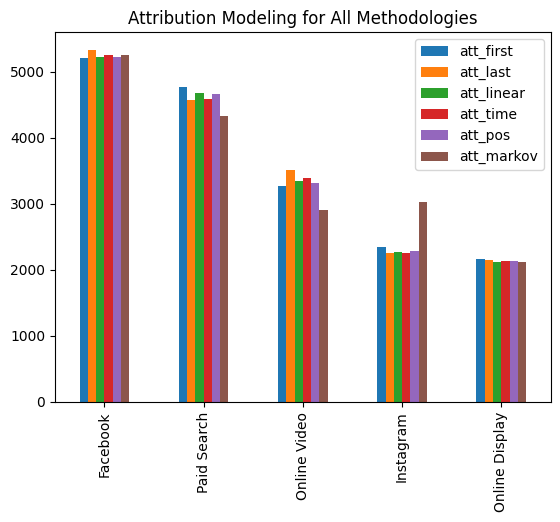

In [211]:
att_all.plot(kind='bar')

plt.title('Attribution Modeling for All Methodologies')
plt.show()